In [41]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import cv2
import torch
import torch.nn as nn
import os
import kornia
import random
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #Prevents an unusual error where displaying images will crash the kernel?
#rcParams['figure.figsize'] = 11,8
plt.gray() #Ensures greyscale images are displayed gray without having to use cmap parameter

<Figure size 432x288 with 0 Axes>

## Functions

In [42]:
#Displays Tensors as image
def imshowTorch(input):
    image = kornia.tensor_to_image(input) #Converts to HWC format
    plt.imshow(image) #As matplotlib requires arrays 

In [43]:
#Converts numpy arrays to Kornia compatable tensors
def toKornia(img):
    print(img.shape)
    img = kornia.image_to_tensor(img) #Kornia in shape BCHW
    print(img.shape)
    # #Adding in dummy axis from: https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
    img = torch.unsqueeze(img, dim=0)
    print(img.shape)
    return img

In [44]:
#Converts images to grayscale
# Implented during in class labs
def img2grayscale(img):
    # img = img.astype(np.float32)/255
    # img = (img[:,:,0]+ img[:,:,1]+ img[:,:,2]) / 3
    img_gr = img.copy()
    img_gr = cv2.cvtColor(img_gr, cv2.COLOR_RGB2GRAY)
    return img_gr

## Part 1

### Load in Images

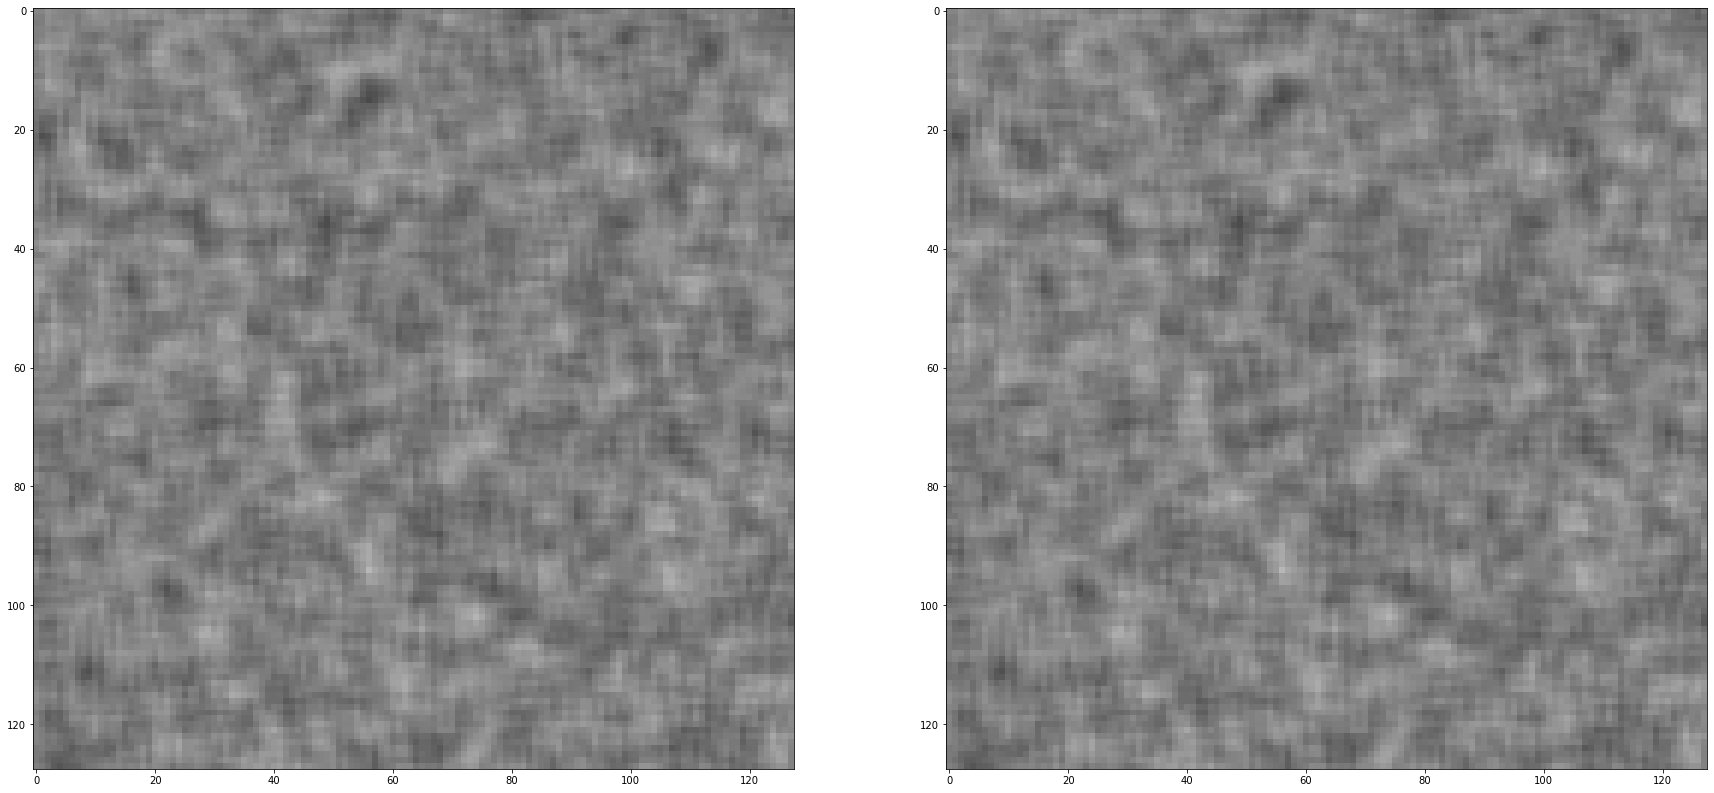

In [45]:
#Start with reading in images
synth0 = cv2.imread('Sequences/synth/synth_0.png')
#plt.imshow(synth1)
synth1 = cv2.imread('Sequences/synth/synth_0.png')

#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(synth0)
ax[1].imshow(synth1)

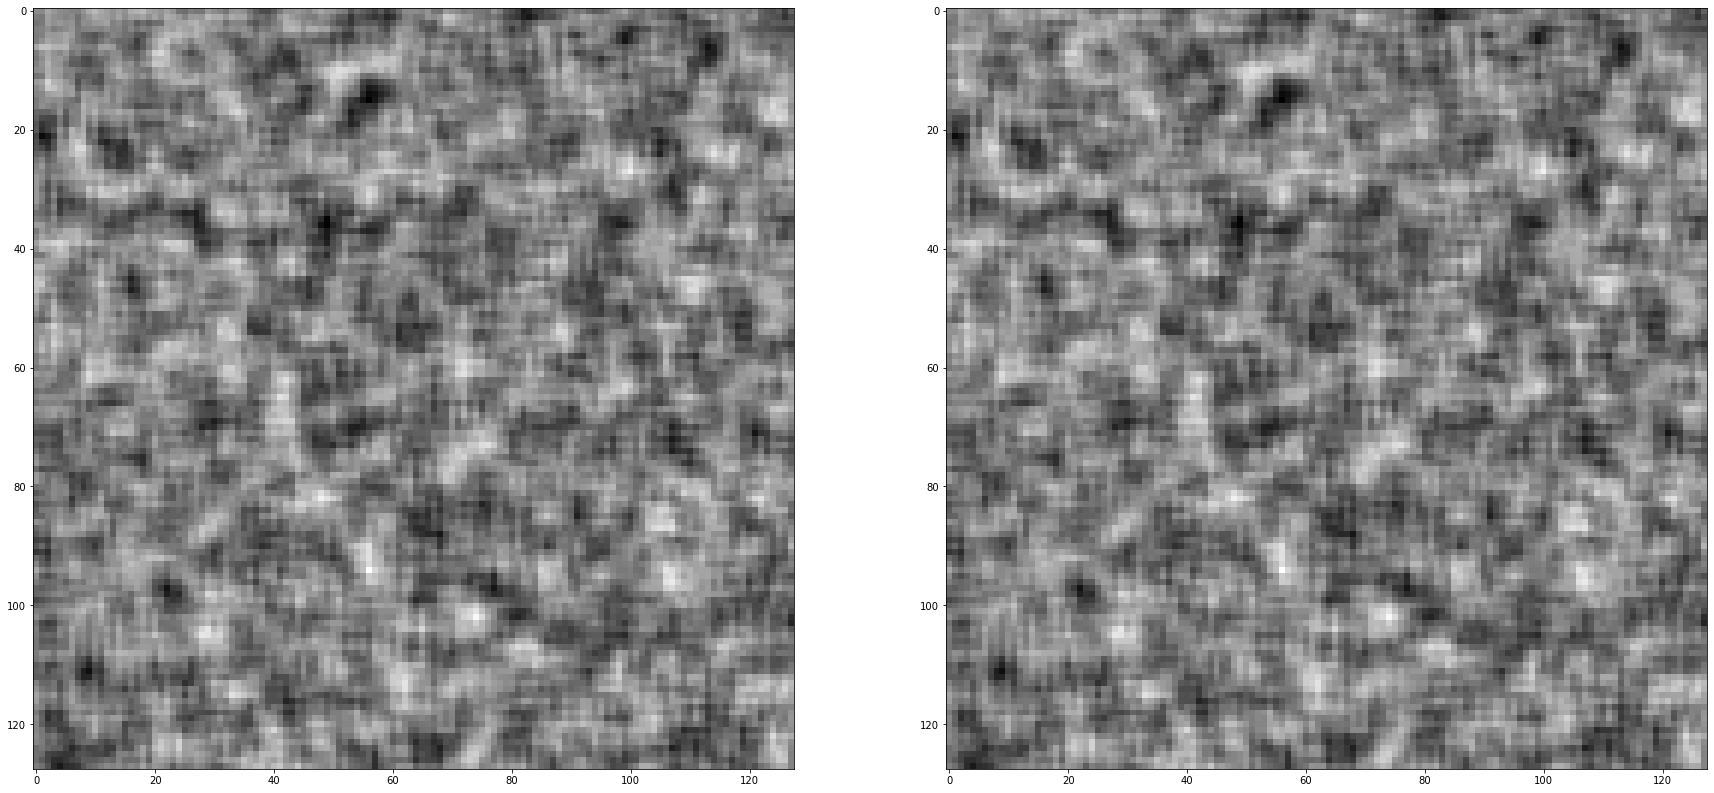

In [46]:
synth0_gr = img2grayscale(synth0)
synth1_gr = img2grayscale(synth1)

fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(synth0_gr)
ax[1].imshow(synth1_gr)

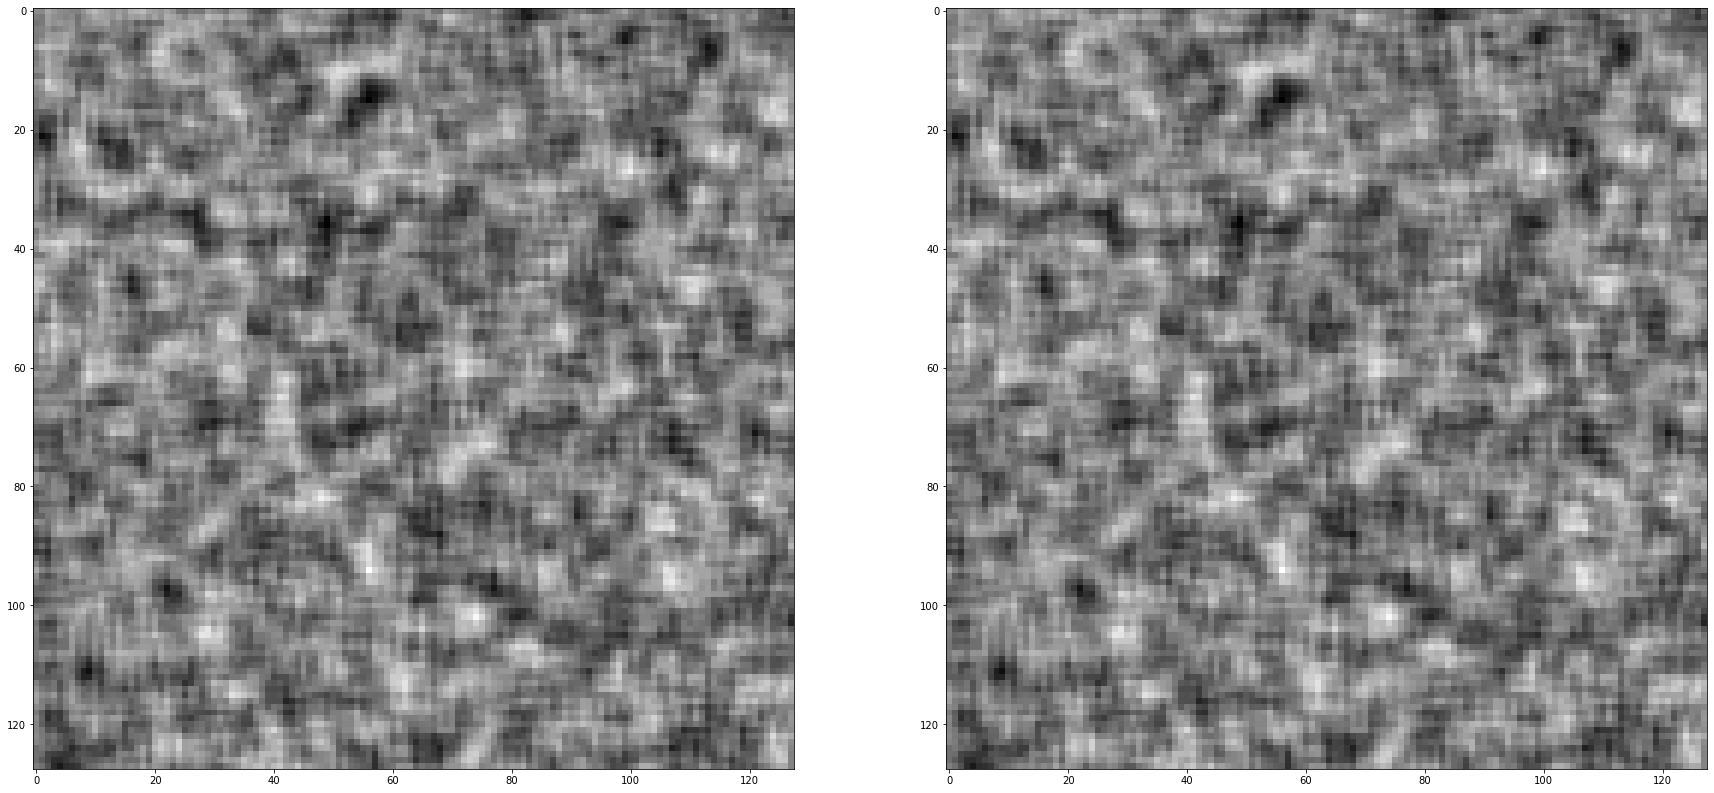

In [47]:
synth0_gr = synth0_gr.astype(np.float32)/255 
synth1_gr = synth1_gr.astype(np.float32)/255 


#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(synth0_gr)
ax[1].imshow(synth1_gr)

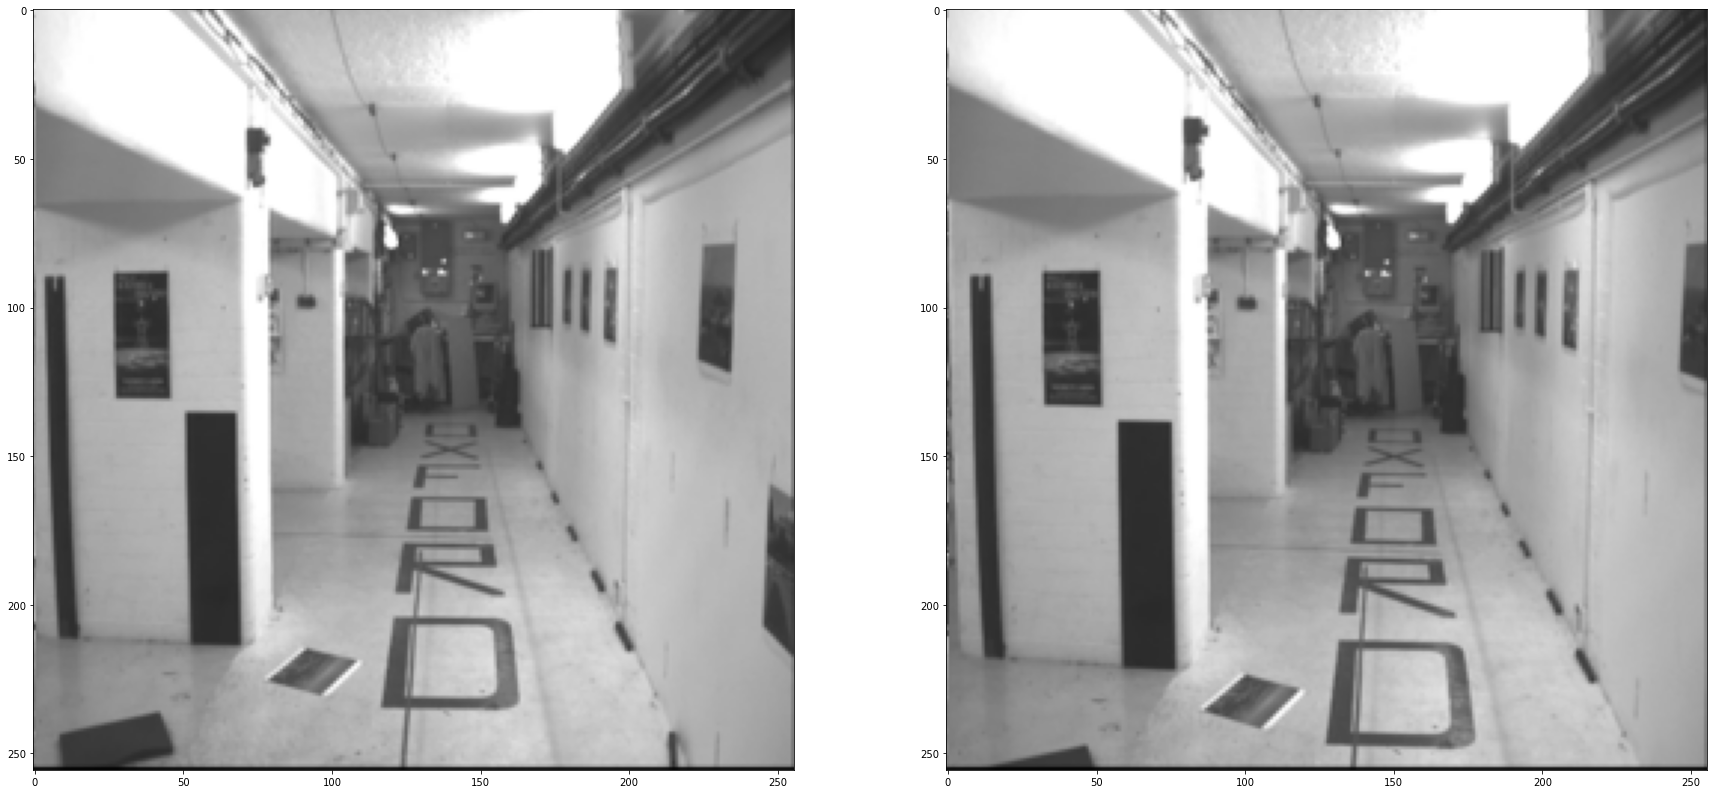

In [48]:
corridor0 = cv2.imread('Sequences/corridor/bt_0.png')
corridor1 = cv2.imread('Sequences/corridor/bt_1.png')

#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(corridor0)
ax[1].imshow(corridor1)

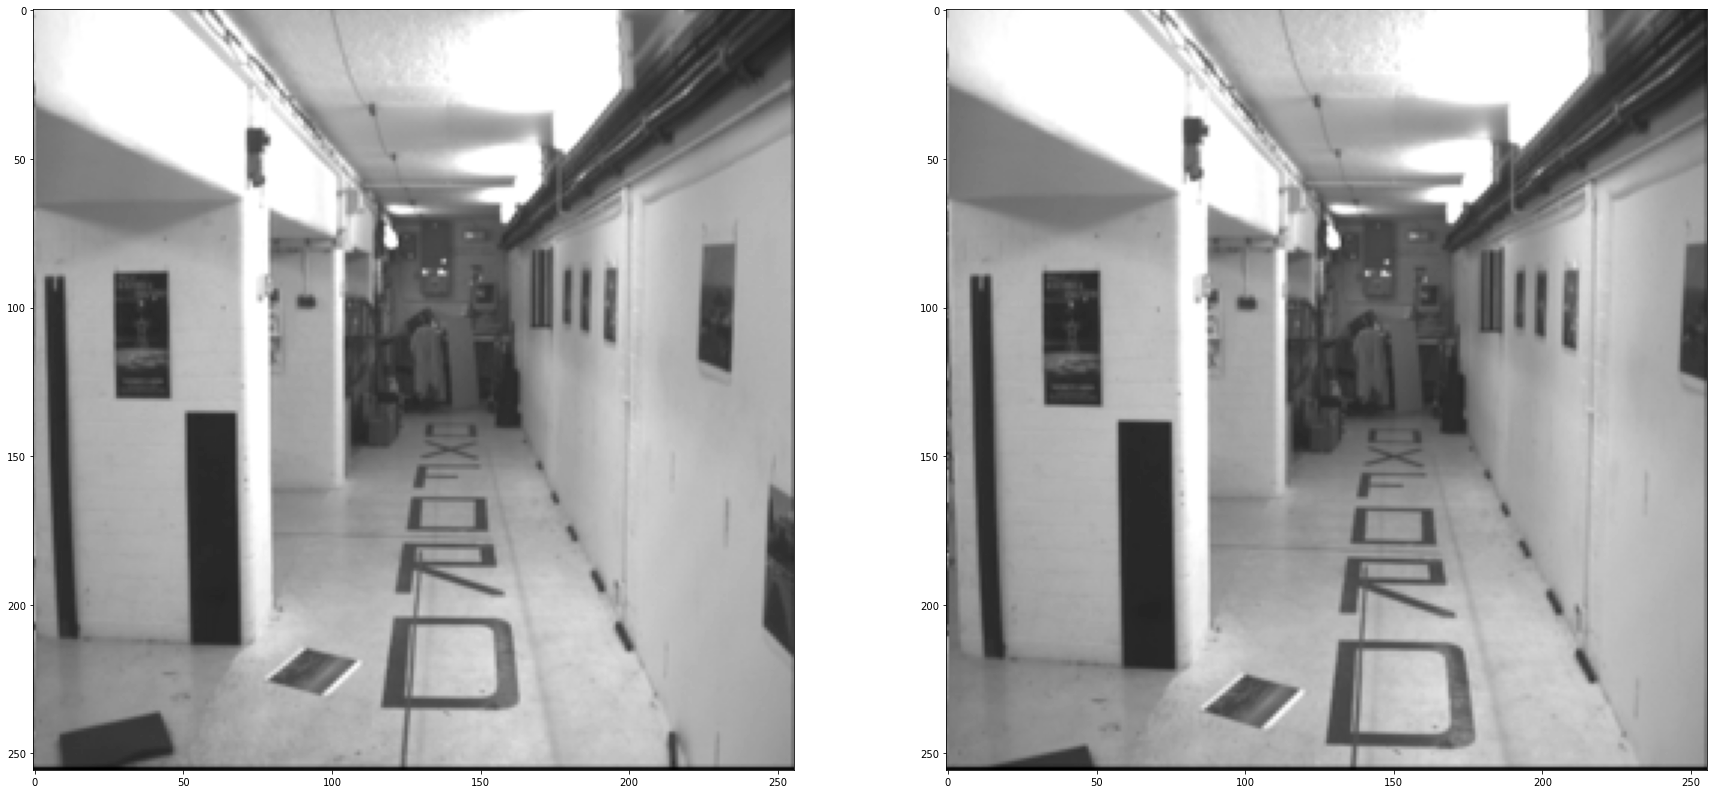

In [49]:
corridor0_gr = img2grayscale(corridor0)
corridor1_gr = img2grayscale(corridor1)

fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(corridor0_gr)
ax[1].imshow(corridor1_gr)

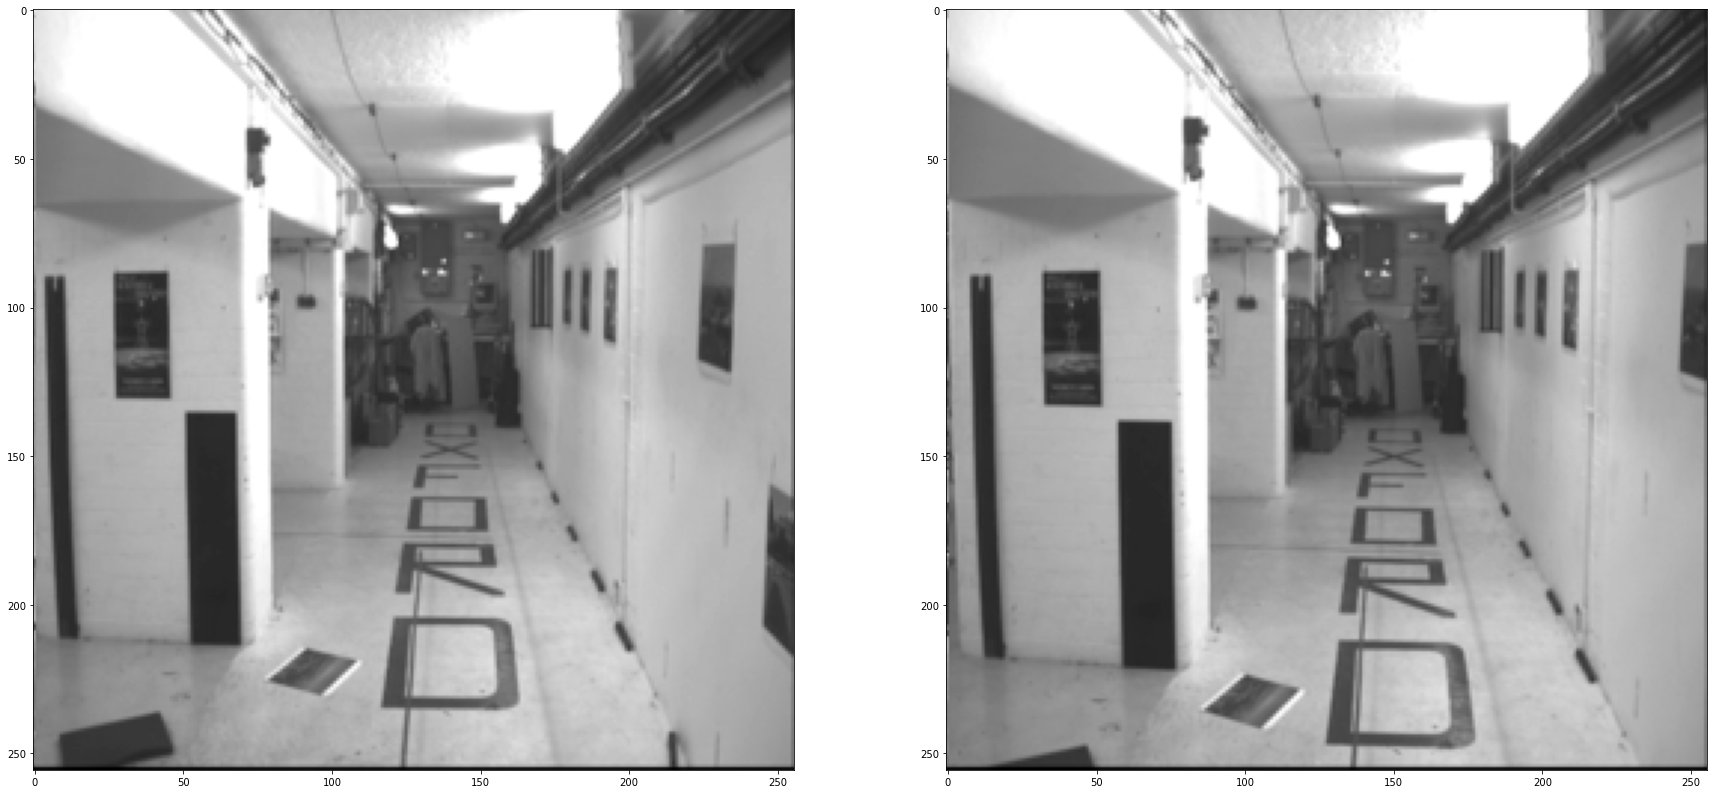

In [50]:
corridor0_gr = corridor0_gr.astype(np.float32)/255 
corridor1_gr = corridor1_gr.astype(np.float32)/255 


#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(corridor0_gr)
ax[1].imshow(corridor1_gr)

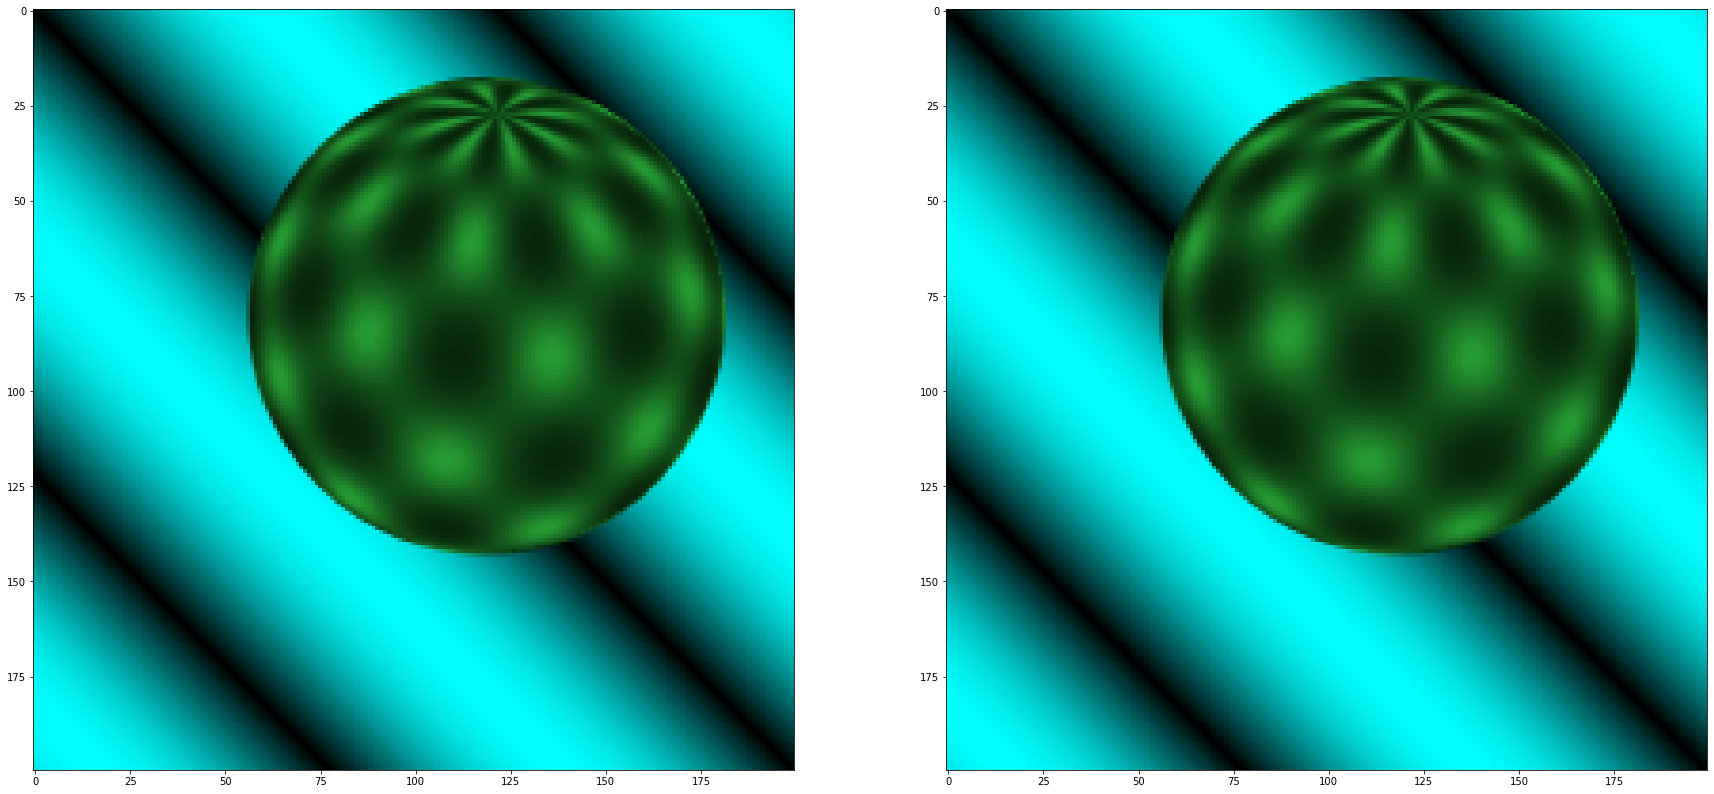

In [51]:
sphere0 = cv2.imread('Sequences/sphere/sphere_0.png')
sphere1 = cv2.imread('Sequences/sphere/sphere_1.png')

#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(sphere0)
ax[1].imshow(sphere1)

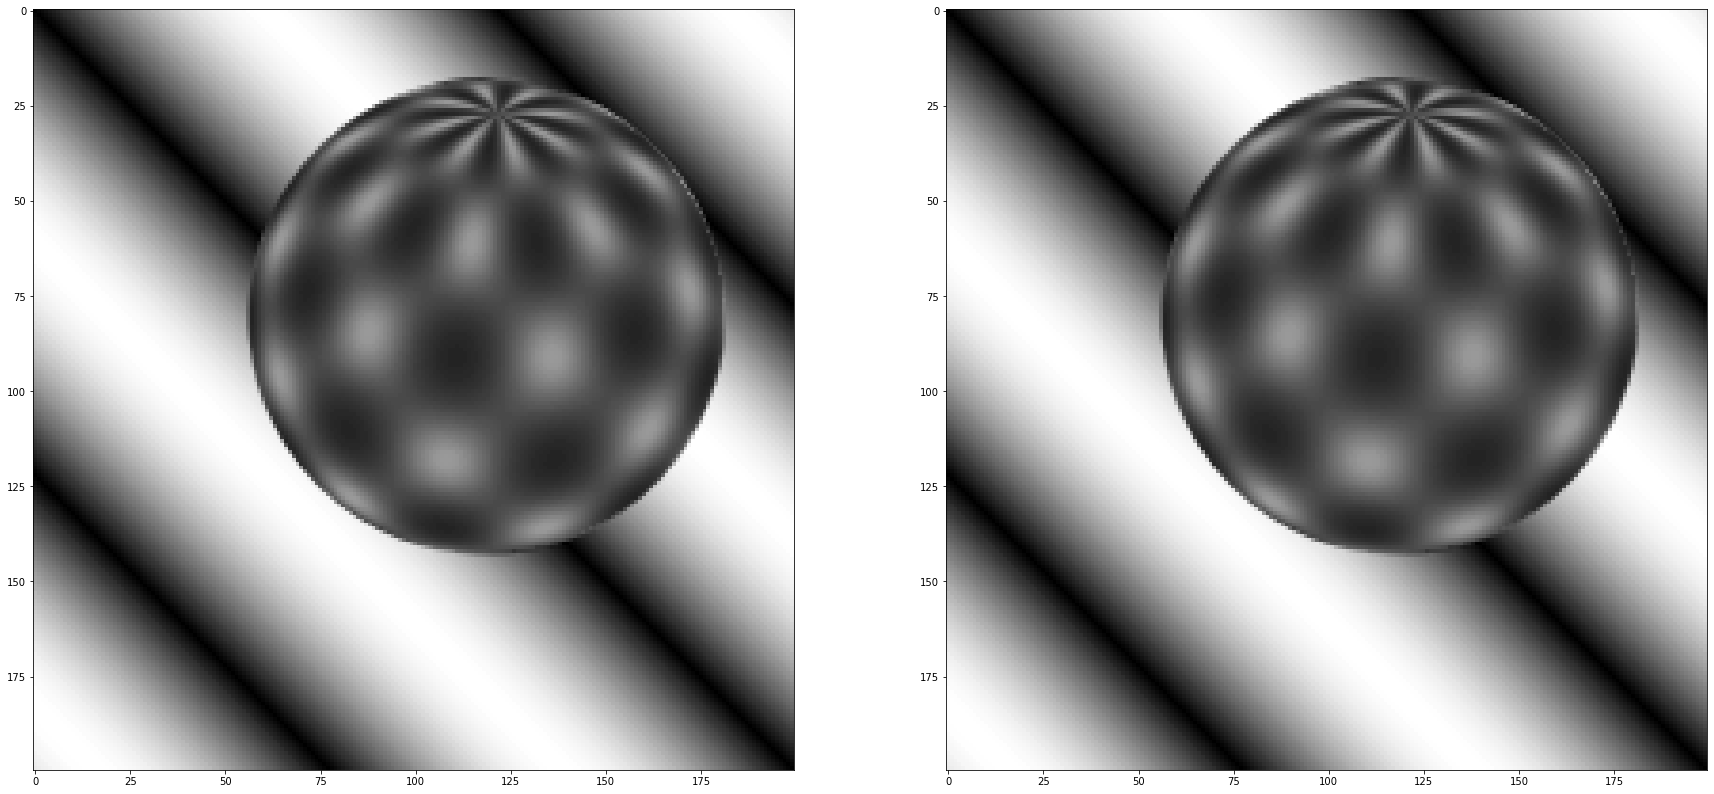

In [52]:
sphere0_gr = img2grayscale(sphere0)
sphere1_gr = img2grayscale(sphere1)

fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(sphere0_gr)
ax[1].imshow(sphere1_gr)

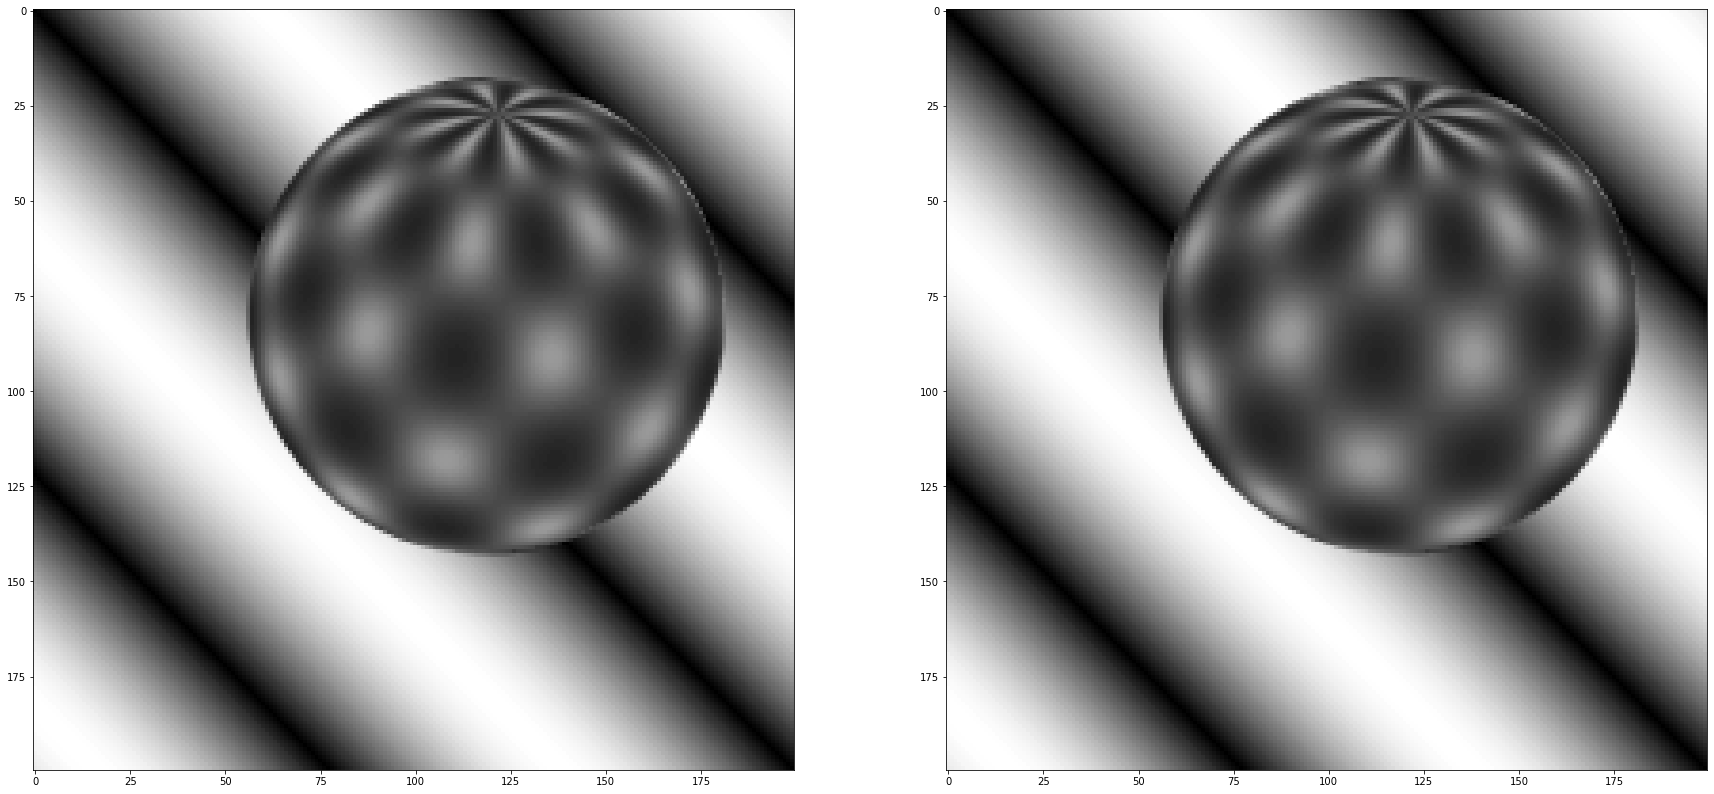

In [53]:
sphere0_gr = sphere0_gr.astype(np.float32)/255 
sphere1_gr = sphere1_gr.astype(np.float32)/255 


#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(sphere0_gr)
ax[1].imshow(sphere1_gr)

### Now compute flow

In [54]:
##This is provided by the A4 document!!

'''
python by:  youngjung uh, Clova ML, Naver
contact:    youngjung.uh@navercorp.com
date:       17 Dec 2018

-------------------------------------------------------------------
----- below comment came from the original (flowToColor.m) --------
-------------------------------------------------------------------
flowToColor(flow, maxFlow) flowToColor color codes flow field, normalize
based on specified value,

flowToColor(flow) flowToColor color codes flow field, normalize
based on maximum flow present otherwise

According to the c++ source code of Daniel Scharstein
Contact: schar@middlebury.edu

Author: Deqing Sun, Department of Computer Science, Brown University
Contact: dqsun@cs.brown.edu
$Date: 2007-10-31 18:33:30 (Wed, 31 Oct 2006) $

Copyright 2007, Deqing Sun.

                        All Rights Reserved

Permission to use, copy, modify, and distribute this software and its
documentation for any purpose other than its incorporation into a
commercial product is hereby granted without fee, provided that the
above copyright notice appear in all copies and that both that
copyright notice and this permission notice appear in supporting
documentation, and that the name of the author and Brown University not be used in
advertising or publicity pertaining to distribution of the software
without specific, written prior permission.

THE AUTHOR AND BROWN UNIVERSITY DISCLAIM ALL WARRANTIES WITH REGARD TO THIS SOFTWARE,
INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY
PARTICULAR PURPOSE.  IN NO EVENT SHALL THE AUTHOR OR BROWN UNIVERSITY BE LIABLE FOR
ANY SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES
WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN
ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF
OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.
'''

import numpy as np

def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


# flowToColor(np.zeros((224,224,2)))


In [55]:
def myFlow(img1, img2, windowLength, tau):
    return 0

In [56]:
fiveTap = [-1, 8, 0, -8, 1]

In [57]:
fiveTap = np.asarray(fiveTap) * (1/12)

In [58]:
fiveTap

array([-0.08333333,  0.66666667,  0.        , -0.66666667,  0.08333333])

In [ ]:
#Use gaussian blur
#cv2.GaussianBlur()